In [1]:
import os 
import math
import geopandas as gp
import xarray as xr
import numpy as np
import geopandas as gp
import pandas as pd
import seaborn as sns
sns.set()

import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from matplotlib import gridspec
from rasterio import features
from affine import Affine
from geopandas import GeoDataFrame
from netCDF4 import Dataset, num2date
from IPython.display import HTML
from shapely.geometry import Point

# Use the CIMIS stations to query SSEBop ncdf

In [2]:
# Directories
stn_dir = '/Users/aakash/Desktop/CIMIS/dailyStns/'
data_dir = '/Users/aakash/Desktop/CIMIS/data/'

# Find the ET data files and unzip
zipfiles = [os.path.join(stn_dir,x) for x in os.listdir(stn_dir) if x.endswith(".zip")]

outdirs = []
for i in zipfiles:
    print("processing " + os.path.split(i)[1][:-4])
    outdirs.append(os.path.join(data_dir,os.path.split(i)[1][:-4]))
    os.system('''unzip {} -d{}'''.format(i, os.path.join(data_dir,os.path.split(i)[1][:-4])))
    
outdirs.sort()

processing dailyStns2008
processing dailyStns2009
processing dailyStns2018
processing dailyStns2002
processing dailyStns2016
processing dailyStns2017
processing dailyStns2003
processing dailyStns2015
processing dailyStns2001
processing dailyStns2000
processing dailyStns2014
processing dailyStns2010
processing dailyStns2004
processing dailyStns2005
processing dailyStns2011
processing dailyStns2007
processing dailyStns2013
processing dailyStns2012
processing dailyStns2006


Text(0.5, 1.0, 'Cimis record length (years)')

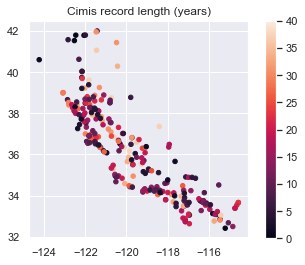

In [3]:
# Read the sites file and make a gdf 
sites = pd.read_excel(os.path.join(data_dir,"cimis_stations.xlsx"))

sdf = sites.copy()

geometry = [Point(xy) for xy in zip(sites.Longitude, sites.Latitude)]
df = sdf.drop(['Longitude', 'Latitude'], axis=1)
crs = {'init': 'epsg:4326'}
gdf = gp.GeoDataFrame(sdf, crs=crs, geometry=geometry)


# Get the length of record for each site 

# Convert "active to datetime now"
dt = []
for i in gdf['Disconnect']:
    if i =="Active":
        dt.append(pd.Timestamp.now())
    else:
        dt.append(pd.to_datetime(i))

# Calc time difference 
gdf['Disconnect2'] = dt
reclen = gdf.Connect - gdf.Disconnect2
nyears = [float(x.days / 365) for x in reclen]
gdf['nyears'] = (np.array(nyears)**2)**(1/2)

# Rename the first column of the gdf 
gdfclist = [x for x in gdf.columns]
gdfclist[0] = 'id'
gdf.columns = gdfclist

# Plot
gdf.plot(column = 'nyears', markersize = 20, legend = True, vmin = 0, vmax = 40)
plt.title("Cimis record length (years)")

In [4]:
# Now get the SSEBop et data and join it to CIMIS 
minx, miny, maxx, maxy = gdf.geometry.total_bounds

# Get the ssebop data
comstr = '''curl -o ../data/ssebop.nc https://cida.usgs.gov/thredds/ncss/ssebopeta/monthly?var=et&north={}&west={}&east={}&south={}&disableProjSubset=on&horizStride=1&time_start=2000-01-01T00%3A00%3A00Z&time_end=2019-10-01T00%3A00%3A00Z&timeStride=1'''.format(maxy, minx, maxx, miny)
# Run following from command line
print(comstr)


curl -o ../data/ssebop.nc https://cida.usgs.gov/thredds/ncss/ssebopeta/monthly?var=et&north=42.003&west=-124.243186&east=-114.558&south=32.411&disableProjSubset=on&horizStride=1&time_start=2000-01-01T00%3A00%3A00Z&time_end=2019-10-01T00%3A00%3A00Z&timeStride=1


In browser, go to:

https://cida.usgs.gov/thredds/ncss/ssebopeta/monthly?var=et&north=42.003&west=-124.243186&east=-114.558&south=32.411&disableProjSubset=on&horizStride=1&time_start=2000-01-01T00%3A00%3A00Z&time_end=2019-10-01T00%3A00%3A00Z&timeStride=1

and run from command line: `mv ~/Downloads/monthly_nc ~/Desktop/CIMIS/data/ssebnop.nc`

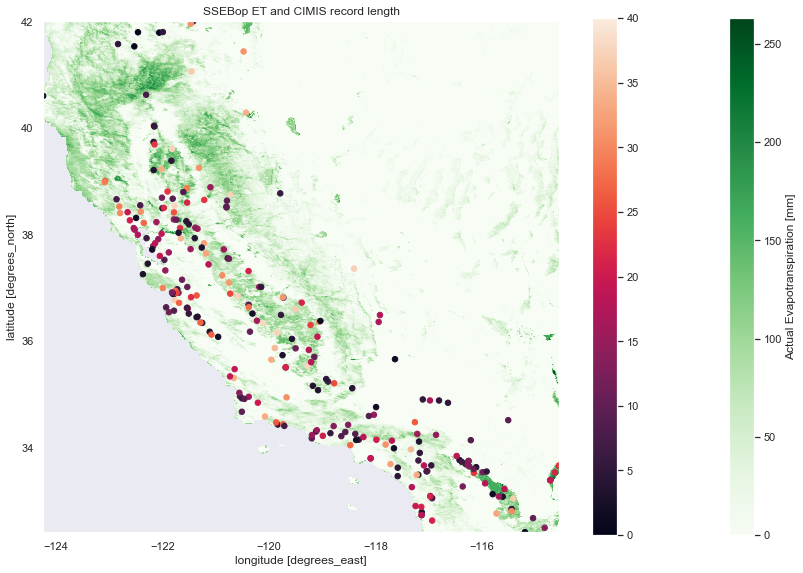

In [5]:
# Find the SSEBop netcdf file and plot a month 

files = [os.path.join("../data",x) for x in os.listdir("../data") if x.endswith(".nc")]
ds = xr.open_dataset(files[0])

fig, ax=plt.subplots(figsize = (12,8))
ds['et'][8].plot(ax = ax, cmap = 'Greens')
gdf.plot(column = 'nyears', markersize = 30, legend = True, vmin = 0, vmax = 40, ax = ax)
plt.title("SSEBop ET and CIMIS record length")
plt.tight_layout()

In [6]:
def geo_idx(dd, dd_array):
    """
     search for nearest decimal degree in an array of decimal degrees and return the index.
     np.argmin returns the indices of minium value along an axis.
     so subtract dd from all values in dd_array, take absolute value and find index of minium.
    """
    geo_idx = (np.abs(dd_array - dd)).argmin()
    return geo_idx

lats = ds.variables['lat'][:]
lons = ds.variables['lon'][:]

# Process the daily CIMIS data to compare with SSEBop 

In [7]:
# Columns after 2014
columns_14_18 = ['id', 'date', 'julian_date', 'ref_eto_qc', 'ref_eto', 'precip_qc','precip', 'srad_qc', 'srad',  'vp_qc', 'vp', 'max_airtemp_qc',  
                 'max_airtemp', 'min_airtemp', 'min_airtemp_qc', 'avg_airtemp_qc','avg_airtemp',  'max_rh_qc','max_rh',  'min_rh_qc', 'min_rh',  
                 'avg_rh_qc', 'avg_rh','dew_pt_qc','dew_pt', 'avg_windspeed', 'avg_windspeed_qc', 'wind_run_qc', 'wind_run',   'avg_soil_temp_qc', 
                 'avg_soil_temp']

# Columns before 2014
columns_00_14 = [ 'id', 'date', 'julian_date', 'srad_qc', 'srad', 'avg_soil_temp_qc', 'avg_soil_temp', 
                 'max_airtemp_qc', 'max_airtemp', 'min_airtemp_qc', 'min_airtemp', 'avg_airtemp_qc', 'avg_airtemp', 'vp_qc','vp', 'avg_windspeed_qc', 
                 'avg_windspeed', 'precip_qc', 'precip', 'max_rh_qc', 'max_rh', 'min_rh_qc', 'min_rh', 'ref_eto_qc', 'ref_eto', 'avg_rh_qc', 'avg_rh',
                 'dew_pt_qc', 'dew_pt', 'wind_run_qc', 'wind_run']


# # These cols are from the Readme
columns_14_18 = ['id', 'date', 'julian_date', 'ref_eto','ref_eto_qc', 'precip', 'precpi_qc', 'srad', 'srad_qc', 'vp', 'vp_qc', 'max_airtemp', 'max_airtemp_qc', 'min_airtemp', 
 'min_airtemp_qc', 'avg_airtemp', 'avg_airtemp_qc', 'max_rh', 'max_rh_qc', 'min_rh', 'min_rh_qc', 'avg_rh', 'avg_rh_qc', 'dew_pt', 'dew_pt_qc', 'avg_windspeed',
          'avg_windspeed_qc', 'wind_run', 'wind_run_qc', 'avg_soil_temp', 'avg_soil']


In [8]:
# Main routine 
all_dfs = []

for i in outdirs[:]:
    print("Processing " + i)
    workingdir = i
    year = int(workingdir[-4:])
    dirfiles = [os.path.join(workingdir,x) for x in os.listdir(workingdir)]

    if year < 2014:
        cols = columns_00_14
    else:
        cols = columns_14_18
    
    dfs = []
    for i in dirfiles:
        
        # Remove file if empty 
        if not os.path.getsize(i) > 1 :
            os.remove(i)
            continue
            
        d = pd.read_csv(i, header = None)
        d.columns = cols
        dfs.append(d)
    
    # Stack and format dfs 
    mdf = pd.concat(dfs)
    mdf.date = pd.to_datetime(mdf.date)
    mdf.set_index('date', inplace = True)
    
    # Convert to float, add nans for missing data
    et = []
    for i in mdf.ref_eto:
        try:
            et.append(float(i))
        except:
            et.append(np.nan)

    # add column to df
    mdf['ref_eto_f'] = et

    # Filter out QC flagged observaitons
    if year < 2014:
        fin = mdf[mdf.ref_eto_qc == '*']
    else:
        fin = mdf[mdf.ref_eto_qc == ' ']
    
    # remove nans 
    fdf = fin[fin['ref_eto_f'].notna()]
    
    # Get the final mean monthly et by site 
    finals = {}
    for i in fdf.id.unique():
        sdf = fdf[fdf.id == i]
        finals[i] = sdf.ref_eto_f.resample("MS").sum()

    monthly = pd.DataFrame.from_dict(finals)
    
    gdf_filt = gdf[gdf['id'].isin(np.array(monthly.columns))]

    # Extract the SSebop data for the lat/longs corresponding to CIMIS sites 
    outdfs = []
    
    print("Processing {} CIMIS stations for {} ".format(len(gdf_filt), str(year)))

    for i in gdf_filt.id.unique()[:]:

        cimis_dat = monthly[i]

        # Extract lat / long value from SSEBop 
        in_lat = np.array(gdf[gdf.id==i].Latitude)
        in_lon = np.array(gdf[gdf.id==i].Longitude)

        lat_idx = geo_idx(in_lat, lats)
        lon_idx = geo_idx(in_lon, lons)

        # Compile the out data 
        for j in cimis_dat.index:
            yr = j.strftime('%Y-%m-%d')
            tempdf = pd.DataFrame([i, yr, cimis_dat[j], ds.sel(time=yr)['et'][lat_idx, lon_idx].values]).T
            tempdf.columns = ['id','date', 'cimis_et', 'ssebop_et']
            outdfs.append(tempdf)
    
    all_dfs.append(pd.concat(outdfs))


Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2000
Processing 104 CIMIS stations for 2000 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2001
Processing 108 CIMIS stations for 2001 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2002
Processing 114 CIMIS stations for 2002 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2003
Processing 113 CIMIS stations for 2003 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2004
Processing 116 CIMIS stations for 2004 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2005
Processing 119 CIMIS stations for 2005 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2006
Processing 121 CIMIS stations for 2006 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2007
Processing 119 CIMIS stations for 2007 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2008
Processing 121 CIMIS stations for 2008 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2009
Processing 123 CIMIS stations for 2009 
Processing /Users/aa

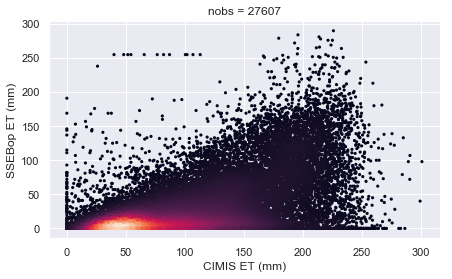

In [9]:
# Scatterplot CIMIS et vs ssebop ET 
dataset = pd.concat(all_dfs)

data = dataset.dropna()
valid = data[~np.isnan(data.ssebop_et.astype(float))]

x,y = valid.cimis_et.astype(float), valid.ssebop_et.astype(float)
xy = np.vstack([x,y])
z = stats.gaussian_kde(xy)(xy)

plt.figure(figsize = (7,4))
plt.scatter(x, y, c=z, s=10, edgecolor='')
plt.title("nobs = {}".format(len(x)))
plt.ylabel("SSEBop ET (mm)")
plt.xlabel("CIMIS ET (mm)")
plt.show()

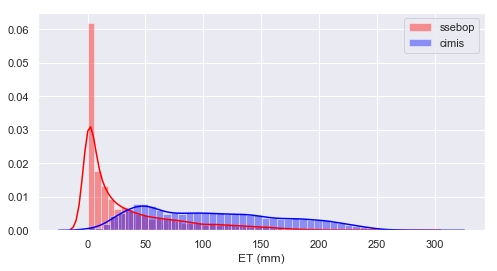

In [10]:
# Plot histograms and distributions

plt.figure(figsize=(8,4))
sns.distplot(valid.ssebop_et.astype(float), color = "red", label = "ssebop")
sns.distplot(valid.cimis_et.astype(float), color= "blue", label = 'cimis')
plt.xlabel("ET (mm)")
plt.legend()
plt.show()


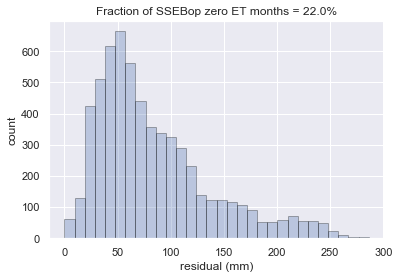

In [11]:
# For days where ssebop ET is zero, plot the corresponding CIMIS et 

ssebop_0 = data.loc[data['ssebop_et'] == 0]
plt.hist(ssebop_0.cimis_et.astype(float), bins = 30, alpha = 0.3, edgecolor='black')
plt.title("Fraction of SSEBop zero ET months = {}%".format(str(round(len(ssebop_0)/len(data),2)*100)))
plt.ylabel("count")
plt.xlabel("residual (mm)")
plt.show()

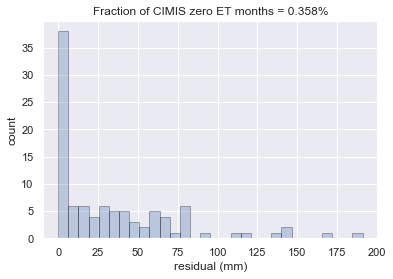

In [12]:
# For days where CIMIS ET is zero, plot the corresponding CIMIS et 

cimis_0 = data.loc[data['cimis_et'] == 0]
plt.hist(cimis_0.ssebop_et.astype(float), bins = 30, alpha = 0.3, edgecolor='black')
plt.title("Fraction of CIMIS zero ET months = {}%".format(str(round(len(cimis_0)/len(data),5)*100)))
plt.ylabel("count")
plt.xlabel("residual (mm)")
plt.show()

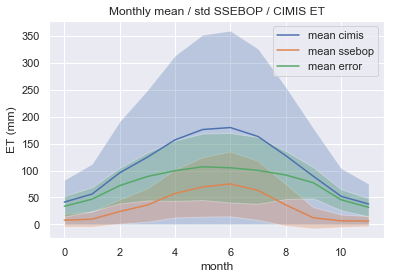

In [13]:
# Plot mean monthly statistics for each dataset, and monthly error 

dataset = pd.concat(all_dfs)

dataset.date = pd.to_datetime(dataset.date)

monthly_error_mean = []
monthly_error_std =[]
monthly_ssebop_mean = []
monthly_ssebop_std = []
monthly_cimis_mean = []
monthly_cimis_std = []

for i in range(1,13):
    # Select all rows for month i 
    mdf = dataset.loc[dataset['date'].dt.month==i]
    
    # Get cimis / ssebop stats 
    monthly_ssebop_mean.append(np.nanmean(mdf.ssebop_et))
    monthly_ssebop_std.append(np.nanstd(mdf.ssebop_et))
    monthly_cimis_mean.append(np.nanmean(mdf.cimis_et))
    monthly_cimis_std.append(np.nanstd(mdf.cimis_et))
    
    mresid = mdf.cimis_et - mdf.ssebop_et
    monthly_error_mean.append(np.nanmean(mresid))
    monthly_error_std.append(np.nanstd(mresid))

# +- 1 std
upper = np.array(monthly_error_mean) + np.array(monthly_error_std)
lower = np.array(monthly_error_mean) - np.array(monthly_error_std)

cimis_upper = np.array(monthly_cimis_mean) + np.array(monthly_cimis_mean)
cimis_lower = np.array(monthly_cimis_mean) - np.array(monthly_cimis_mean)

ssebop_upper = np.array(monthly_ssebop_mean) + np.array(monthly_ssebop_std)
ssebop_lower = np.array(monthly_ssebop_mean) - np.array(monthly_ssebop_std)


plt.plot(monthly_cimis_mean, label = 'mean cimis')
plt.fill_between(range(0,12),cimis_lower, cimis_upper, alpha = 0.3)

plt.plot(monthly_ssebop_mean, label = 'mean ssebop')
plt.fill_between(range(0,12),ssebop_lower, ssebop_upper, alpha = 0.3)

plt.plot(monthly_error_mean, label = 'mean error')
plt.fill_between(range(0,12),lower, upper, alpha = 0.3)
plt.ylabel("ET (mm)")
plt.title("Monthly mean / std SSEBOP / CIMIS ET")
plt.xlabel("month")
plt.legend()
plt.show()

In [14]:
# Plot mean error for each site 
dataset = pd.concat(all_dfs)

site_errs_m = {}
site_errs_v = {}

for i in dataset.id.unique():
    # Select all rows for month i 
    mdf = dataset.loc[dataset['id']==i]
    err = mdf.cimis_et - mdf.ssebop_et
    site_errs_m[i] = [np.nanmean(err)]
    site_errs_v[i] = [np.nanvar(err)]

    
err_m_df = pd.DataFrame.from_dict(site_errs_m).T
err_v_df = pd.DataFrame.from_dict(site_errs_v).T

err_m_df.columns = ['mean_err']
err_v_df.columns = ['var_err']

err_df = pd.concat([err_m_df, err_v_df], axis = 1)

err_df = err_df[~(err_df['mean_err'] <= -50)]  # Filter one strangely anomalous site 

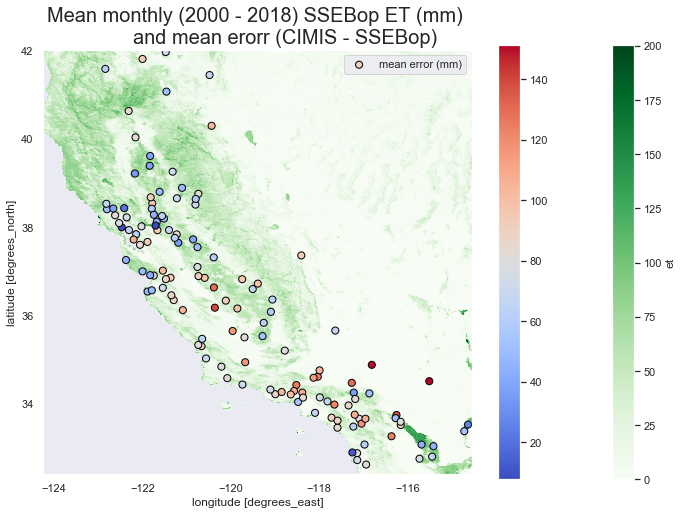

In [15]:
# Find the SSEBop mean ET and plot the errors at each site 

asdf = pd.merge(gdf_filt, err_df, left_on = "id", right_index = True)

files = [os.path.join("../data",x) for x in os.listdir("../data") if x.endswith(".nc")]
ds = xr.open_dataset(files[0])
et_mean = ds['et'].mean(axis = 0) # Spatial means 
et_mean = et_mean.where(et_mean!=180) # remove nans

fig, ax=plt.subplots(figsize = (12,8))
et_mean.plot(cmap = 'Greens',ax = ax)
asdf.plot(column = 'mean_err', markersize = 50, edgecolor = 'black', cmap = 'coolwarm',legend = True, label = "mean error (mm)", ax = ax)
plt.title('''Mean monthly (2000 - 2018) SSEBop ET (mm) 
          and mean erorr (CIMIS - SSEBop)''', size = 20)
plt.legend()
plt.show()

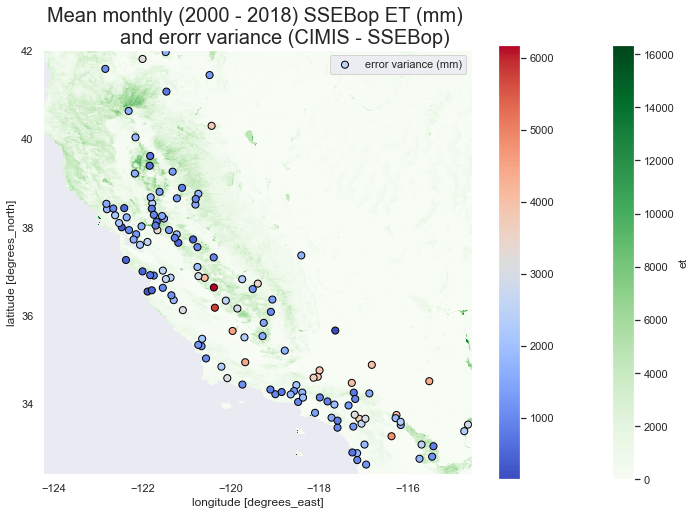

In [16]:
# Find the SSEBop mean ET and plot the error VARIANCES at each site 

asdf = pd.merge(gdf_filt, err_df, left_on = "id", right_index = True)

files = [os.path.join("../data",x) for x in os.listdir("../data") if x.endswith(".nc")]
ds = xr.open_dataset(files[0])
et_var = ds['et'].var(axis = 0) # Spatial means 
et_var = et_var.where(et_var!=1.350000e+04) # remove nans

fig, ax=plt.subplots(figsize = (12,8))
et_var.plot(cmap = 'Greens', ax = ax)
asdf.plot(column = 'var_err', markersize = 50, edgecolor = 'black', cmap = 'coolwarm',legend = True, label = "error variance (mm)", ax = ax)
plt.title('''Mean monthly (2000 - 2018) SSEBop ET (mm) 
          and erorr variance (CIMIS - SSEBop)''', size = 20)
plt.legend()
plt.show()

In [17]:
# Apply A tempoarl bias correction 

In [41]:
# Loop through the dataset and add the monthly mean difference to each point 

outdat = []

for i in ds['et'][:]:
        
    month = pd.to_datetime(i.time.values).month
    ds_mth = i + monthly_error_mean[month-1]
    outdat.append(ds_mth)

# after the loop re-combine the DataArrays
stacked = xr.concat(outdat[:], dim="dataset")
cor_mean = stacked.mean(axis = 0) # Spatial means 
cor_plot = cor_mean.where(cor_mean!=253.28389) # remove nans

In [48]:
# Plot The Correction 

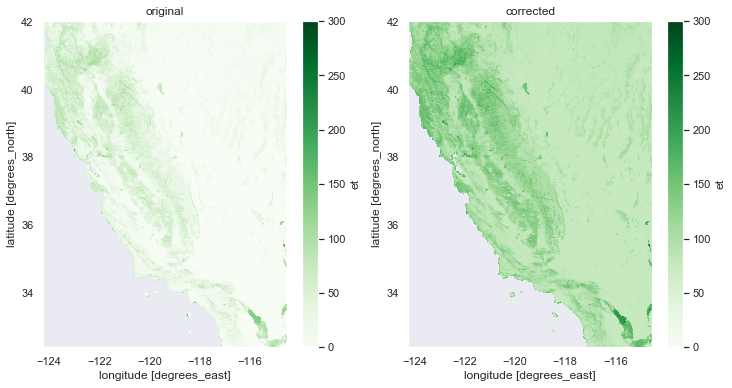

In [70]:
plt.figure(figsize = (12,6))

plt.subplot(121)
et_mean.plot(cmap = "Greens", vmin = 0, vmax= 300)
plt.title("original")

plt.subplot(122)f
cor_plot.plot(cmap = "Greens", vmin = 0, vmax= 300)
plt.title("corrected")

# plt.tight_layout()
plt.show()

In [366]:
# Do the same for each SSEBOP / CIMIS pair 

# out_dfs = []

# for i in gdf_filt.id.unique()[:]:

#     cimis_dat = monthly[i]

#     # Extract lat / long value from SSEBop 
#     in_lat = np.array(gdf[gdf.id==i].Latitude)
#     in_lon = np.array(gdf[gdf.id==i].Longitude)

#     lat_idx = geo_idx(in_lat, lats)
#     lon_idx = geo_idx(in_lon, lons)
    
#     dfs = []

#     # Compile the out data 
#     for j in cimis_dat.index:
#         date = j.strftime('%Y-%m-%d')
#         midx = pd.to_datetime(date).month - 1
#         cor = ds.sel(time=yr)['et'][lat_idx, lon_idx].values + monthly_error_mean[midx]
#         tempdf = pd.DataFrame([i, yr, cimis_dat[j], cor]).T
#         tempdf.columns = ['id','date', 'cimis_et', 'ssebop_et_cor']
#         dfs.append(tempdf)
        
#     out_dfs.append(pd.concat(dfs))

# Main routine 


cor_dfs = []

for i in outdirs[:]:
    print("Processing " + i)
    workingdir = i
    year = int(workingdir[-4:])
    dirfiles = [os.path.join(workingdir,x) for x in os.listdir(workingdir)]

    if year < 2014:
        cols = columns_00_14
    else:
        cols = columns_14_18
    
    dfs = []
    for i in dirfiles:
        
        # Remove file if empty 
        if not os.path.getsize(i) > 1 :
            os.remove(i)
            continue
            
        d = pd.read_csv(i, header = None)
        d.columns = cols
        dfs.append(d)
    
    # Stack and format dfs 
    mdf = pd.concat(dfs)
    mdf.date = pd.to_datetime(mdf.date)
    mdf.set_index('date', inplace = True)
    
    # Convert to float, add nans for missing data
    et = []
    for i in mdf.ref_eto:
        try:
            et.append(float(i))
        except:
            et.append(np.nan)

    # add column to df
    mdf['ref_eto_f'] = et

    # Filter out QC flagged observaitons
    if year < 2014:
        fin = mdf[mdf.ref_eto_qc == '*']
    else:
        fin = mdf[mdf.ref_eto_qc == ' ']
    
    # remove nans 
    fdf = fin[fin['ref_eto_f'].notna()]
    
    # Get the final mean monthly et by site 
    finals = {}
    for i in fdf.id.unique():
        sdf = fdf[fdf.id == i]
        finals[i] = sdf.ref_eto_f.resample("MS").sum()

    monthly = pd.DataFrame.from_dict(finals)
    
    gdf_filt = gdf[gdf['id'].isin(np.array(monthly.columns))]

    # Extract the SSebop data for the lat/longs corresponding to CIMIS sites 
    outdfs = []
    
    print("Processing {} CIMIS stations for {} ".format(len(gdf_filt), str(year)))

    for i in gdf_filt.id.unique()[:]:

        cimis_dat = monthly[i]

        # Extract lat / long value from SSEBop 
        in_lat = np.array(gdf[gdf.id==i].Latitude)
        in_lon = np.array(gdf[gdf.id==i].Longitude)

        lat_idx = geo_idx(in_lat, lats)
        lon_idx = geo_idx(in_lon, lons)

        # Compile the out data 
        for j in cimis_dat.index:
            date = j.strftime('%Y-%m-%d')
            midx = pd.to_datetime(date).month - 1
            cor = ds.sel(time=date)['et'][lat_idx, lon_idx].values+ monthly_error_mean[midx]
            tempdf = pd.DataFrame([i, yr, cimis_dat[j], cor]).T
            tempdf.columns = ['id','date', 'cimis_et', 'ssebop_et_cor']
            
            outdfs.append(tempdf)
    
    cor_dfs.append(pd.concat(outdfs))



Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2000
Processing 104 CIMIS stations for 2000 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2001
Processing 108 CIMIS stations for 2001 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2002
Processing 114 CIMIS stations for 2002 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2003
Processing 113 CIMIS stations for 2003 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2004
Processing 116 CIMIS stations for 2004 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2005
Processing 119 CIMIS stations for 2005 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2006
Processing 121 CIMIS stations for 2006 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2007
Processing 119 CIMIS stations for 2007 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2008
Processing 121 CIMIS stations for 2008 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2009
Processing 123 CIMIS stations for 2009 
Processing /Users/aa

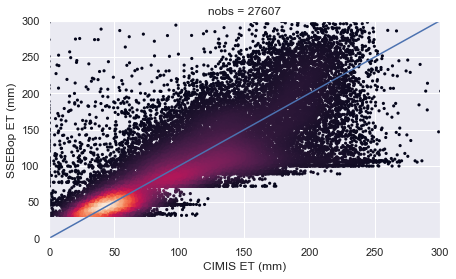

In [367]:
# Scatterplot the corrected SSEBop ET vs CIMIS et 
cordat = pd.concat(cor_dfs)

cor = cordat.dropna()
corvalid = cor[~np.isnan(cor.ssebop_et_cor.astype(float))]

x,y = corvalid.cimis_et.astype(float), corvalid.ssebop_et_cor.astype(float)
xy = np.vstack([x,y])
z = stats.gaussian_kde(xy)(xy)

plt.figure(figsize = (7,4))
plt.scatter(x, y, c=z, s=10, edgecolor='')
plt.plot([0,300],[0,300])

plt.title("nobs = {}".format(len(x)))
plt.ylabel("SSEBop ET (mm)")
plt.xlabel("CIMIS ET (mm)")
plt.xlim(0,300)
plt.ylim(0,300)
plt.show()

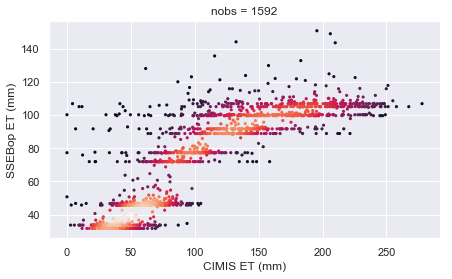

In [361]:
# Scatterplot The correction 
ds_cor = pd.concat(out_dfs)

data_cor = ds_cor.dropna()
valid_cor = data_cor[~np.isnan(data_cor.ssebop_et_cor.astype(float))]

x,y = valid_cor.cimis_et.astype(float), valid_cor.ssebop_et_cor.astype(float)
xy = np.vstack([x,y])
z = stats.gaussian_kde(xy)(xy)

plt.figure(figsize = (7,4))
plt.scatter(x, y, c=z, s=10, edgecolor='')
plt.title("nobs = {}".format(len(x)))
plt.ylabel("SSEBop ET (mm)")
plt.xlabel("CIMIS ET (mm)")
plt.show()

In [ ]:
plt.plot(x, skewnorm.pdf(x, valid.ssebop_et.astype(float).sample(500)),
       'r-', lw=5, alpha=0.6, label='skewnorm pdf')

In [244]:
from sklearn.preprocessing import QuantileTransformer, PowerTransformer

rng = np.random.RandomState(0)
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',random_state=rng)
bc = PowerTransformer(method='box-cox')


In [247]:
X_trans_qt = qt.fit_transform(ssebop_arr, cimis_arr)
X_trans_bc = bc.fit_transform(ssebop_arr, cimis_arr)

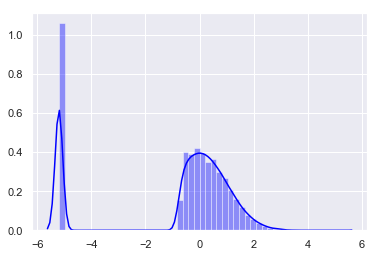

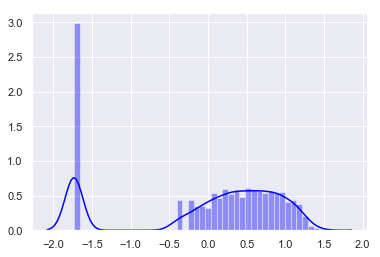

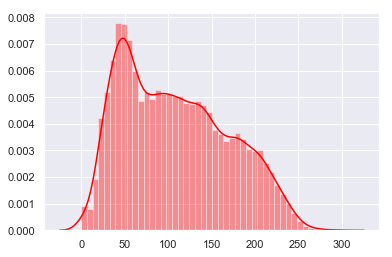

In [248]:
sns.distplot(X_trans_qt, color = 'blue') #, edgecolor = 'black', bins = 100)
plt.show()
sns.distplot(X_trans_bc, color = 'blue') #, edgecolor = 'black', bins = 100)
plt.show()
sns.distplot(cimis_arr, color = 'red',)
plt.show()

In [313]:
# For days where ssebop ET is zero, set the ET equal to the CIMIS et

# Scatterplot CIMIS et vs ssebop ET 
dataset = pd.concat(all_dfs)
data = dataset.dropna()

# Drop nans
valid = data[~np.isnan(data.ssebop_et.astype(float))]
# Find ssebop zeros
cor0 = valid.cimis_et.loc[valid['ssebop_et'] == 0]
# Replace with cimis data for zero days 
mod = valid.copy()
mod['ssebop_et'][mod['ssebop_et'] == 0] = cor0

# Remove cimis zeros, since boxcox cant handle them 
modcor = mod.loc[valid['cimis_et'] != 0]

In [277]:
# Fit distributions to the corrected data 

In [314]:
# Format the arrays
ssebop_arr =  np.array(modcor.ssebop_et.astype(float)).reshape(modcor.shape[0],1)
cimis_arr =  np.array(modcor.cimis_et.astype(float)).reshape(modcor.shape[0],1)

# Transformt he ssebop lognormal dist
rng = np.random.RandomState(0)
qt = QuantileTransformer(n_quantiles=500, output_distribution='normal',random_state=rng)
bc = PowerTransformer(method='box-cox')

# Fit
X_trans_qt = qt.fit_transform(ssebop_arr, cimis_arr)
X_trans_bc = bc.fit_transform(ssebop_arr, cimis_arr)

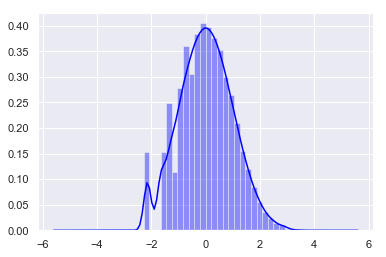

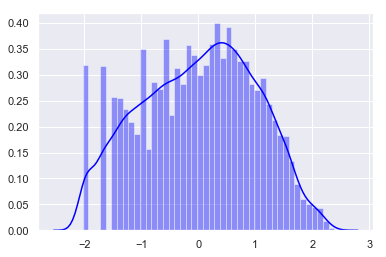

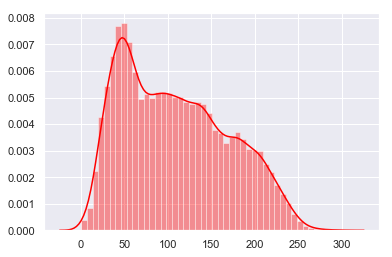

In [315]:
sns.distplot(X_trans_qt, color = 'blue') #, edgecolor = 'black', bins = 100)
plt.show()
sns.distplot(X_trans_bc, color = 'blue') #, edgecolor = 'black', bins = 100)
plt.show()
sns.distplot(cimis_arr, color = 'red',)
plt.show()

In [353]:
stats.rv_discrete.rvs(cor0, 100)

TypeError: super(type, obj): obj must be an instance or subtype of type

In [331]:

x,y = cimis_arr.astype(float), X_trans_qt.astype(float)
xy = np.vstack([x,y])
z = stats.gaussian_kde(xy)(xy)

plt.figure(figsize = (7,4))
plt.scatter(x, y, c=z, s=10, edgecolor='')
plt.title("nobs = {}".format(len(x)))
plt.ylabel("SSEBop ET (mm)")
plt.xlabel("CIMIS ET (mm)")
plt.show()

ValueError: array must not contain infs or NaNs

In [340]:
plt.plot(sorted(stats.norm.ppf(x.dropna())))

AttributeError: 'numpy.ndarray' object has no attribute 'dropna'

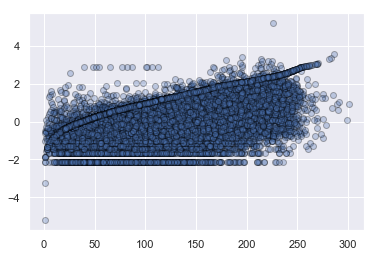

In [332]:
plt.scatter(x,y, edgecolor = 'black', alpha = 0.3)

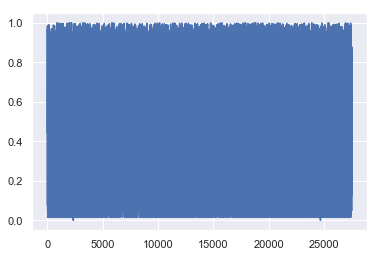

In [348]:
s = stats.norm.cdf(X_trans_qt)
t = s[s!=np.nan]
plt.plot(s)

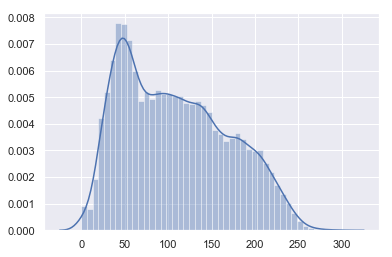

In [281]:
sns.distplot(cimis_arr)

In [302]:
len(ssebop_arr[ssebop_arr<0])

0

In [155]:
# Main routine 
cor_dfs = []

for i in outdirs[:]:
    print("Processing " + i)
    workingdir = i
    year = int(workingdir[-4:])
    dirfiles = [os.path.join(workingdir,x) for x in os.listdir(workingdir)]

    if year < 2014:
        cols = columns_00_14
    else:
        cols = columns_14_18
    
    dfs = []
    for i in dirfiles:
        
        # Remove file if empty 
        if not os.path.getsize(i) > 1 :
            os.remove(i)
            continue
            
        d = pd.read_csv(i, header = None)
        d.columns = cols
        dfs.append(d)
    
    # Stack and format dfs 
    mdf = pd.concat(dfs)
    mdf.date = pd.to_datetime(mdf.date)
    mdf.set_index('date', inplace = True)
    
    # Convert to float, add nans for missing data
    et = []
    for i in mdf.ref_eto:
        try:
            et.append(float(i))
        except:
            et.append(np.nan)

    # add column to df
    mdf['ref_eto_f'] = et

    # Filter out QC flagged observaitons
    if year < 2014:
        fin = mdf[mdf.ref_eto_qc == '*']
    else:
        fin = mdf[mdf.ref_eto_qc == ' ']
    
    # remove nans 
    fdf = fin[fin['ref_eto_f'].notna()]
    
    # Get the final mean monthly et by site 
    finals = {}
    for i in fdf.id.unique():
        sdf = fdf[fdf.id == i]
        finals[i] = sdf.ref_eto_f.resample("MS").sum()

    monthly = pd.DataFrame.from_dict(finals)
    
    gdf_filt = gdf[gdf['id'].isin(np.array(monthly.columns))]

    # Extract the SSebop data for the lat/longs corresponding to CIMIS sites 
    outdfs = []
    
    print("Processing {} CIMIS stations for {} ".format(len(gdf_filt), str(year)))

    for i in gdf_filt.id.unique()[:]:

        cimis_dat = monthly[i]

        # Extract lat / long value from SSEBop 
        in_lat = np.array(gdf[gdf.id==i].Latitude)
        in_lon = np.array(gdf[gdf.id==i].Longitude)

        lat_idx = geo_idx(in_lat, lats)
        lon_idx = geo_idx(in_lon, lons)

        # Compile the out data 
        for j in cimis_dat.index:
            date = j.strftime('%Y-%m-%d')
            midx = pd.to_datetime(date).month - 1
            cor = ds.sel(time=date)['et'][lat_idx, lon_idx].values * np.exp(monthly_error_mean[midx] / monthly_error_std[midx])
            tempdf = pd.DataFrame([i, yr, cimis_dat[j], cor]).T
            tempdf.columns = ['id','date', 'cimis_et', 'ssebop_et_cor']
            
            outdfs.append(tempdf)
    
    cor_dfs.append(pd.concat(outdfs))


Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2000
Processing 104 CIMIS stations for 2000 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2001
Processing 108 CIMIS stations for 2001 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2002
Processing 114 CIMIS stations for 2002 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2003
Processing 113 CIMIS stations for 2003 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2004
Processing 116 CIMIS stations for 2004 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2005
Processing 119 CIMIS stations for 2005 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2006
Processing 121 CIMIS stations for 2006 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2007
Processing 119 CIMIS stations for 2007 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2008
Processing 121 CIMIS stations for 2008 
Processing /Users/aakash/Desktop/CIMIS/data/dailyStns2009
Processing 123 CIMIS stations for 2009 
Processing /Users/aa

In [162]:
# Scatterplot CIMIS et vs ssebop ET 
cordat = pd.concat(cor_dfs)

cor = cordat.dropna()
corvalid = cor[~np.isnan(cor.ssebop_et_cor.astype(float))]

x,y = corvalid.cimis_et.astype(float), corvalid.ssebop_et_cor.astype(float)
xy = np.vstack([x,y])
z = stats.gaussian_kde(xy)(xy)


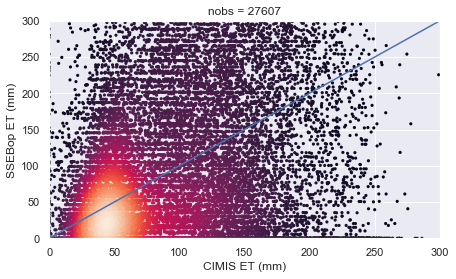

In [157]:


plt.figure(figsize = (7,4))
plt.scatter(x, y, c=z, s=10, edgecolor='')
plt.plot([0,300],[0,300])

plt.title("nobs = {}".format(len(x)))
plt.ylabel("SSEBop ET (mm)")
plt.xlabel("CIMIS ET (mm)")
plt.xlim(0,300)
plt.ylim(0,300)
plt.show()

In [175]:
# generate data
N = 100
x = np.linspace(0,20,N)
ϵ = np.random.normal(loc = 0.0, scale = 5.0, size = N)
y = 3*x + ϵ
df = pd.DataFrame({'y':y, 'x':x})
df['constant'] = 1

In [183]:
import statsmodels.api as sm
from statsmodels.base.model import GenericLikelihoodModel
from scipy.optimize import minimize


In [184]:
# split features and target
X = df[['constant', 'x']]
# fit model and summarize
sm.OLS(y,X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.909
Model:                            OLS   Adj. R-squared:                  0.908
Method:                 Least Squares   F-statistic:                     974.0
Date:                Thu, 26 Mar 2020   Prob (F-statistic):           1.04e-52
Time:                        12:52:20   Log-Likelihood:                -309.36
No. Observations:                 100   AIC:                             622.7
Df Residuals:                      98   BIC:                             627.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
constant       1.2484      1.070      1.166      0.246      -0.875       3.372
x              2.8852      0.092     31.209      0.000       2.702       3.069
==============================================================================
Omnibus:                        0.979   Durbin-Watson:                   1.898
Prob(Omnibus):                  0.613   Jarque-Bera (JB):                1.076
Skew:                          -0.180   Prob(JB):                        0.584
Kurtosis:                       2.641   Cond. No.                         23.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [185]:
# define likelihood function
def MLERegression(params):
 intercept, beta, sd = params[0], params[1], params[2] # inputs are guesses at our parameters
 yhat = intercept + beta*x # predictions
# next, we flip the Bayesian question
# compute PDF of observed values normally distributed around mean (yhat)
# with a standard deviation of sd
 negLL = -np.sum( stats.norm.logpdf(y, loc=yhat, scale=sd) )
# return negative LL
 return(negLL)

In [186]:
guess = np.array([5,5,2])
results = minimize(MLERegression, guess, method = 'Nelder-Mead', 
 options={'disp': True})

Optimization terminated successfully.
         Current function value: 309.361066
         Iterations: 101
         Function evaluations: 180


In [187]:
results

 final_simplex: (array([[1.24843705, 2.88522544, 5.33704051],
       [1.24836643, 2.88523096, 5.33702496],
       [1.24842557, 2.88522898, 5.33707245],
       [1.24846885, 2.88522685, 5.33703733]]), array([309.36106567, 309.36106568, 309.36106568, 309.36106568]))
           fun: 309.36106567494613
       message: 'Optimization terminated successfully.'
          nfev: 180
           nit: 101
        status: 0
       success: True
             x: array([1.24843705, 2.88522544, 5.33704051])

In [188]:
# drop results into df and round to match statsmodels
resultsdf = pd.DataFrame({'coef':results['x']})
resultsdf.index=['constant','x','sigma']   
np.round(resultsdf.head(2), 4)

,coef
constant,1.2484
x,2.8852


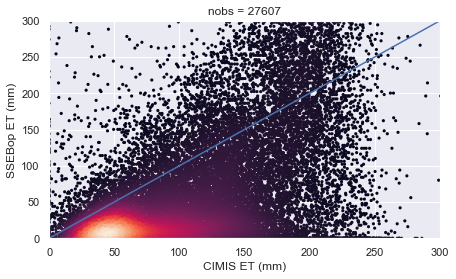

In [139]:
plt.figure(figsize = (7,4))
plt.scatter(x, y, c=z, s=10, edgecolor='')
plt.plot([0,300],[0,300])

plt.title("nobs = {}".format(len(x)))
plt.ylabel("SSEBop ET (mm)")
plt.xlabel("CIMIS ET (mm)")
plt.xlim(0,300)
plt.ylim(0,300)
plt.show()

In [135]:
for i in range(0,12):
    print(monthly_error_mean[i] * monthly_error_std[i] / len(gdf))

2.4505816646728733
3.96600287197966
9.097125625516341
15.083016531272886
21.336222085278244
25.21037482382826
25.895400790749793
23.739193953029496
15.671266667630803
8.548114739614364
3.40466528313675
2.018653063053778


In [133]:
len(gdf)

262

In [ ]:
# Plot dists of all observations 

ERROR! Session/line number was not unique in database. History logging moved to new session 356


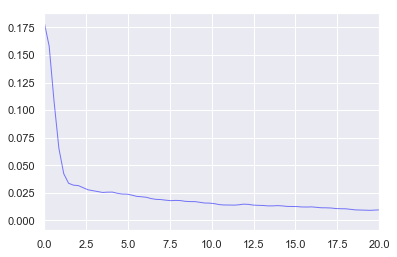

In [355]:
x =  valid.ssebop_et.astype(float)+ 0.00001
x_grid = np.linspace(np.min(x), np.max(x), 1000)
kde = stats.gaussian_kde(x, bw_method=0.5 / x.std(ddof=1))
pdf = kde.evaluate(x_grid)

plt.plot(x_grid, pdf, color='blue', alpha=0.5, lw=1)
plt.title("")
plt.xlim(0,20)
plt.show()

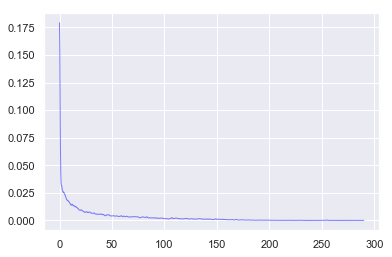

In [356]:
plt.plot(x_grid, pdf, color='blue', alpha=0.5, lw=1)
plt.title("")
# plt.xlim(-1,8)
plt.show()

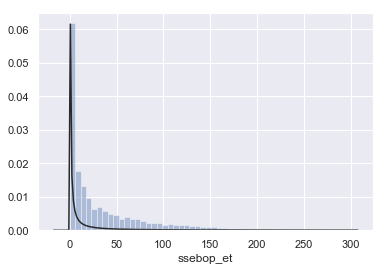

In [354]:
sns.distplot(valid.ssebop_et.astype(float), kde = False, fit=stats.lognorm) #log normal distribution

(0, 25)

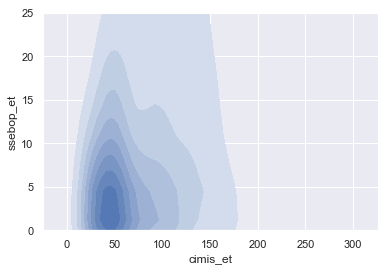

In [357]:
sns.kdeplot(valid.cimis_et.astype(float),valid.ssebop_et.astype(float),shade=True,shade_lowest = False)
plt.ylim(0,25)

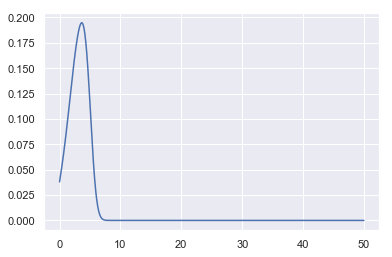

In [358]:
import numpy as np
import pandas as pd
from sklearn.neighbors import KernelDensity

arr = np.log(np.array(valid.ssebop_et.astype(float)).reshape(-1,1) + 0.0000001)

kde = KernelDensity(kernel='gaussian', bandwidth=0.75).fit(arr) 

X=np.linspace(0,50,1000)[:, np.newaxis]

log_density_values=kde.score_samples(X)
density=np.exp(log_density_values)
plt.plot(X,density)

In [ ]:
# Plot the distribution of the log of the nonzero SSEBop ET values
arr = valid.ssebop_et.astype(float)+ 0.0000000001
arr = np.log(data.loc[data['ssebop_et'] != 0].ssebop_et.astype(float))

log_x = (arr  - np.mean(arr)) / np.var(arr)
sns.distplot(log_x.dropna())

In [ ]:
X = valid.ssebop_et.astype(float) + 0.000000001
μ1 = np.mean(valid.ssebop_et.astype(float))
μ2 = np.mean(valid.cimis_et.astype(float))
σ1 = np.std(valid.ssebop_et.astype(float))
σ2 = np.std(valid.cimis_et.astype(float))

transformed = (μ2 + (X - μ1 )) / (σ1/σ2)
sns.distplot(transformed, bins = 30)
sns.distplot(valid.cimis_et.astype(float), bins = 30)

In [ ]:
# sns.distplot(valid.ssebop_et.astype(float), color = 'red')
sns.distplot(transformed, color= 'blue', bins = 30)

In [ ]:
# Scatterplot CIMIS et vs ssebop ET 
mask = transformed>120
data = dataset.dropna()
valid = data[~np.isnan(data.ssebop_et.astype(float))]

x,y = valid.cimis_et.astype(float)[mask], transformed[mask]
xy = np.vstack([x,y])
z = stats.gaussian_kde(xy)(xy)

plt.figure(figsize = (7,4))
plt.scatter(x, y, c=z, s=10, edgecolor='')
plt.title("nobs = {}".format(len(x)))
plt.ylabel("SSEBop ET (mm)")
plt.xlabel("CIMIS ET (mm)")
plt.show()

In [ ]:
# Scale the transformed data to cimis min / max 
normed = (transformed-min(data.cimis_et.astype(float)))/(max(data.cimis_et.astype(float))-min(data.cimis_et.astype(float)))

# Scatterplot CIMIS et vs ssebop ET 
mask = transformed>120
data = dataset.dropna()
valid = data[~np.isnan(data.ssebop_et.astype(float))]

x,y = valid.cimis_et.astype(float)[mask], normed[mask]
xy = np.vstack([x,y])
z = stats.gaussian_kde(xy)(xy)

plt.figure(figsize = (7,4))
plt.scatter(x, y, c=z, s=10, edgecolor='')
plt.title("nobs = {}".format(len(x)))
plt.ylabel("SSEBop ET (mm)")
plt.xlabel("CIMIS ET (mm)")
plt.show()

In [ ]:
# Calc the CIMIS distribution 

nparam_density_func = stats.kde.gaussian_kde(data.cimis_et.astype(float))
x = np.linspace(-20, 300, 1000)
nparam_density = nparam_density_func(x)

loc_param, scale_param = stats.norm.fit(data.cimis_et.astype(float))
param_density = stats.norm.pdf(x, loc=loc_param, scale=scale_param)

fig, ax = plt.subplots(figsize=(10, 6))
ax.hist(data.cimis_et.astype(float), bins=30, normed=True)
ax.plot(x, nparam_density, 'r-', label='non-parametric density (smoothed by Gaussian kernel)')
ax.plot(x, param_density, 'k--', label='parametric density')
ax.legend(loc='best')

In [ ]:
from scipy.interpolate import interp1d
fit = interp1d(data.ssebop_et.astype(float), data.cimis_et.astype(float))
sdf = fit(data.ssebop_et.astype(float))[~np.isnan(t(data.ssebop_et.astype(float)))]
sns.distplot(sdf)
sns.distplot(data.cimis_et.astype(float))

In [ ]:
x,y = valid.cimis_et.astype(float)[~np.isnan(fit(valid.ssebop_et.astype(float)))], sdf
xy = np.vstack([x,y])
z = stats.gaussian_kde(xy)(xy)

plt.figure(figsize = (7,4))
plt.scatter(x, y, c=z, s=10, edgecolor='')
plt.title("nobs = {}".format(len(x)))
plt.ylabel("SSEBop ET (mm)")
plt.xlabel("CIMIS ET (mm)")
plt.show()

In [ ]:
# Plot mean monthly statistics for each dataset, and monthly error 

dataset = pd.concat(all_dfs)

dataset.date = pd.to_datetime(dataset.date)

monthly_error_mean = []
monthly_error_std =[]
monthly_ssebop_mean = []
monthly_ssebop_std = []
monthly_cimis_mean = []
monthly_cimis_std = []

for i in range(1,13):
    # Select all rows for month i 
    mdf = dataset.loc[dataset['date'].dt.month==i]
    
    # Get cimis / ssebop stats 
    monthly_ssebop_mean.append(np.nanmean(mdf.ssebop_et))
    monthly_ssebop_std.append(np.nanstd(mdf.ssebop_et))
    monthly_cimis_mean.append(np.nanmean(mdf.cimis_et))
    monthly_cimis_std.append(np.nanstd(mdf.cimis_et))
    
    mresid = mdf.cimis_et - mdf.ssebop_et
    monthly_error_mean.append(np.nanmean(mresid))
    monthly_error_std.append(np.nanstd(mresid))

# +- 1 std
upper = np.array(monthly_error_mean) + np.array(monthly_error_std)
lower = np.array(monthly_error_mean) - np.array(monthly_error_std)

cimis_upper = np.array(monthly_cimis_mean) + np.array(monthly_cimis_mean)
cimis_lower = np.array(monthly_cimis_mean) - np.array(monthly_cimis_mean)

ssebop_upper = np.array(monthly_ssebop_mean) + np.array(monthly_ssebop_std)
ssebop_lower = np.array(monthly_ssebop_mean) - np.array(monthly_ssebop_std)


plt.plot(monthly_cimis_mean, label = 'mean cimis')
plt.fill_between(range(0,12),cimis_lower, cimis_upper, alpha = 0.3)

plt.plot(monthly_ssebop_mean, label = 'mean ssebop')
plt.fill_between(range(0,12),ssebop_lower, ssebop_upper, alpha = 0.3)

plt.plot(monthly_error_mean, label = 'mean error')
plt.fill_between(range(0,12),lower, upper, alpha = 0.3)
plt.ylabel("ET (mm)")
plt.title("Monthly mean / std SSEBOP / CIMIS ET")
plt.xlabel("month")
plt.legend()
plt.show()

In [ ]:
monthly_ssebop